In [1]:
#!pip install tqdm

In [2]:
#!pip install pandas

In [3]:
#!pip install nltk

In [4]:
#!pip install -U spacy

In [5]:
#!pip install es_core_news_sm

In [6]:
#!pip install scikit-learn

In [7]:
#!pip install matplotlib

In [8]:
#!pip install seaborn

In [9]:
#!pip install cltk

In [10]:
#!pip install scikit-plot

In [11]:
#!pip install imblearn

In [12]:
import os
os.chdir("/home/martinaleo/.ssh/authorship/pydro")

from src.dro import DistributionalRandomOversampling



In [13]:
# !ls /home/martinaleo/.ssh/authorship/pydro/src


# Imports

In [14]:
from tqdm import tqdm

from data_loader import load_spanish_corpus

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


import re

from nltk import download
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import spacy
import es_core_news_sm

from splitting__ import Segmentation

from helpers__ import get_function_words

from features import ( 
    FeaturesFunctionWords, 
    FeaturesDVEX, 
    FeaturesMendenhall, 
    FeaturesSentenceLength, 
    FeaturesPOST, 
    FeatureSetReductor,
    HstackFeatureSet
)


from sklearn.feature_selection import SelectKBest, chi2

from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    RandomizedSearchCV,
    GridSearchCV,
)

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)

from scikitplot.metrics import plot_roc
from sklearn.calibration import CalibratedClassifierCV

from imblearn.over_sampling import SMOTE


/home/martinaleo/.local/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'es_core_news_sm' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/home/martinaleo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Loading

In [15]:
documents, authors, filenames = load_spanish_corpus(path='/home/martinaleo/authorship/src/data/Corpus')

loading: /home/martinaleo/authorship/src/data/Corpus: 100%|██████████| 31/31 [00:00<00:00, 1228.26it/s]


In [16]:
print(filenames)

['Agustín de Rojas Villandrando - El viaje entretenido', 'Alonso de Castillo Solórzano - Aventuras del Bachiller Trapaza', 'Alonso de Castillo Solórzano - Las harpías en Madrid y coche de las estafas', 'Avellaneda - Quijote apocrifo', 'Cervantes - El amante liberal', 'Cervantes - El casamiento engañoso', 'Cervantes - El celoso extremeño', 'Cervantes - El coloquio de los perros', 'Cervantes - El licenciado Vidriera', 'Cervantes - La Gitanilla', 'Cervantes - La dos doncellas', 'Cervantes - La española inglesa', 'Cervantes - La fuerza de la sangre', 'Cervantes - La ilustre fregona', 'Cervantes - La señora Cornelia', 'Cervantes - Los trabajos de Persiles y Sigismunda', 'Cervantes - Rinconete y Cortadillo', 'Cristóbal Suárez de Figueroa - El pasajero', 'Guillén de Castro - El nacimiento de Montesinos', 'Guillén de Castro - Las mocedades del Cid', 'Juan Ruiz de Alarcón y Mendoza - La verdad sospechosa', 'Lope de Vega - Guzmán el Bravo', 'Lope de Vega - La desdicha por la honra', 'Lope de Veg

In [17]:
np.unique(authors, return_counts=True)

(array(['Agustín de Rojas Villandrando ', 'Alonso de Castillo Solórzano ',
        'Avellaneda ', 'Cervantes ', 'Cristóbal Suárez de Figueroa ',
        'Guillén de Castro ', 'Juan Ruiz de Alarcón y Mendoza ',
        'Lope de Vega ', 'Mateo Alemán ', 'Pasamonte ', 'Pérez de Hita ',
        'Quevedo ', 'Tirso de Molina '], dtype='<U31'),
 array([ 1,  2,  1, 13,  1,  2,  1,  4,  2,  1,  1,  1,  1]))

# Data Cleaning

### Noise elimination

In [18]:
documents = [document.lower() for document in documents]
documents = [(re.sub(r'\[(?:(?!\[|\]).)*\]', '', document)) for document in documents] 
# elimina le parti di testo delimitate da [] e che non contengono al loro interno ][

authors = [author.rstrip() for author in authors]

# Segmentation & Splitting

In [19]:
target = 'Cervantes'
y_labels =  (target, 'Other')

In [20]:
X = documents
y = [1 if author.rstrip() == target else 0 for author in authors]
# y_cat = [1 if author.rstrip() == target else 0 for author in authors]

positive_class = np.sum(y)
negative_class = len(y) - positive_class

print('Target class:', target)
print(f'Positive samples: {positive_class}')
print(f'Negative samples: {negative_class}')

Target class: Cervantes
Positive samples: 13
Negative samples: 18


In [21]:
X_dev, X_test, y_dev, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [22]:
positive_class_dev = np.sum(y_dev)
negative_class_dev = len(y_dev) - positive_class_dev
pos_ratio_dev = round(positive_class_dev / len(y_dev), 2)

positive_class_test = np.sum(y_test)
negative_class_test = len(y_test) - positive_class_test
pos_ratio_test = round(positive_class_test / len(y_test), 2)

tot_pos_ratio = (positive_class_dev + positive_class_test) / len(y)

print(f'Positive samples: {positive_class_dev}')
print(f'Negative samples: {negative_class_dev}')
print()
print(f'Positive samples: {positive_class_test}')
print(f'Negative samples: {negative_class_test}')

Positive samples: 9
Negative samples: 12

Positive samples: 4
Negative samples: 6


In [23]:
print('Positive samples ratio:', 
    '\nTrain:', pos_ratio_dev, 
    '\nTest:', pos_ratio_test, 
    '\nWhole dataset:',tot_pos_ratio)

Positive samples ratio: 
Train: 0.43 
Test: 0.4 
Whole dataset: 0.41935483870967744


In [24]:
from splitting__ import Segmentation


segmentator_dev = Segmentation(split_policy='by_sentence')
splitted_docs_dev = segmentator_dev.fit_transform(documents=X_dev, authors=y_dev)
groups_dev = segmentator_dev.groups
# lista composta da due liste, una contenente le frasi, una contenente gli autori

generating fragments:   0%|          | 0/21 [00:00<?, ?it/s]

generating fragments: 100%|██████████| 21/21 [00:08<00:00,  2.40it/s]


In [25]:
segmentator_test = Segmentation(split_policy='by_sentence')
splitted_docs_test = segmentator_test.fit_transform(documents=X_test, authors=y_test)
groups_test = segmentator_test.groups

generating fragments:   0%|          | 0/10 [00:00<?, ?it/s]

generating fragments: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


In [26]:
print((len(splitted_docs_dev[0]), len(splitted_docs_dev[1]), len(groups_dev)),
(len(splitted_docs_test[0]), len(splitted_docs_test[1]), len(groups_test)))

(6283, 6283, 6283) (2436, 2436, 2436)


In [27]:
np.unique(splitted_docs_dev[1], return_counts=True), np.unique(splitted_docs_test[1], return_counts=True)

((array([0, 1]), array([5029, 1254])), (array([0, 1]), array([2139,  297])))

In [28]:
dev_pos_class_ratio = np.sum(splitted_docs_dev[1]) / len(splitted_docs_dev[1])
test_pos_class_ratio = np.sum(splitted_docs_test[1]) / len(splitted_docs_test[1])
tot_pos_class_ratio = (np.sum(splitted_docs_dev[1]) + np.sum(splitted_docs_test[1])) / (len(splitted_docs_dev[1]) + len(splitted_docs_test[1]))

In [29]:
print('Positive samples ratio:', 
      '\nTrain:', dev_pos_class_ratio, 
      '\nTest:', test_pos_class_ratio,
      '\nWhole dataset:', tot_pos_class_ratio)

Positive samples ratio: 
Train: 0.19958618494349833 
Test: 0.12192118226600986 
Whole dataset: 0.17788737240509234


In [30]:
X_dev = splitted_docs_dev[0]
y_dev = splitted_docs_dev[1]
groups_dev = segmentator_dev.groups

X_test = splitted_docs_test[0]
y_test = splitted_docs_test[1]
groups_test = segmentator_test.groups
#y__ = list(zip(splitted_docs[1], groups))

len(X_dev), len(y_dev), len(groups_dev),len(X_test), len(y_test), len(groups_test)

(6283, 6283, 6283, 2436, 2436, 2436)

# Data Preparation

In [31]:
fuction_ws = get_function_words(lang='spanish')

In [32]:
# vectorizers
function_words_extractor = FeaturesFunctionWords(language='spanish')
mendenhall_extractor = FeaturesMendenhall(upto=20)
words_masker = FeaturesDVEX(function_words=fuction_ws)
sentence_len_extractor = FeaturesSentenceLength()
POS_extractor = FeaturesPOST(language='spanish')

loading cache from .postcache/dict.pkl


In [33]:
%%time
fw_reductor = FeatureSetReductor(function_words_extractor) 
fw_red = fw_reductor.fit_transform(X_dev, authors=y_dev)
fw_red_test = fw_reductor.transform(X_test)

me_reductor = FeatureSetReductor(mendenhall_extractor)
me_red = me_reductor.fit_transform(X_dev, authors=y_dev)
me_red_test = me_reductor.transform(X_test)

wm_reductor = FeatureSetReductor(words_masker)
wm_red = wm_reductor.fit_transform(X_dev, authors=y_dev)
wm_red_test = wm_reductor.transform(X_test)

pos_reductor = FeatureSetReductor(POS_extractor)
pos_red = pos_reductor.fit_transform(X_dev, authors=y_dev)
pos_red_test = pos_reductor.transform(X_test)


FeatureSetReductor for FeaturesFunctionWords
features in: 313 k: 156

FeatureSetReductor for FeaturesMendenhall
features in: 18 k: 18

FeatureSetReductor for FeaturesDVEX
features in: 387 k: 194

FeatureSetReductor for FeaturesPOST
features in: 9 k: 9

CPU times: user 1min 44s, sys: 271 ms, total: 1min 44s
Wall time: 1min 44s


In [34]:
# from sklearn.preprocessing import Normalizer # new!

# def l2_normalize(features, features_test):
#     normalizer = Normalizer()
#     features_norm = normalizer.fit_transform(features)
#     features_norm_test = normalizer.transform(features_test)
#     return features_norm, features_norm_test

In [35]:
# fw_norm, fw_norm_test = l2_normalize(fw_red, fw_red_test)
# me_norm, me_norm_test = l2_normalize(me_red, me_red_test)
# wm_norm, wm_norm_test = l2_normalize(wm_red, wm_red_test)
# pos_norm, pos_norm_test = l2_normalize(pos_red, pos_red_test)

In [36]:
hstacker = HstackFeatureSet(function_words_extractor, words_masker, mendenhall_extractor, POS_extractor)
hstacked_features = hstacker._hstack([fw_red, me_red, wm_red, pos_red])
# #hstacked_features = hstacker._hstack([fw_norm, me_norm, wm_norm, pos_norm])

In [37]:
hstacked_features_test = hstacker._hstack([fw_red_test, me_red_test, wm_red_test, pos_red_test])
#hstacked_features_test = hstacker._hstack([fw_norm_test, me_norm_test, wm_norm_test, pos_norm_test])

# Model Building

In [79]:

def build_model(X_dev, y_dev, groups, X_test,model=None, print_scores=True, param_grid=None, pipe=False, feature_extractor=None):
    if not model:
        clf = LinearSVC(random_state=42, class_weight='balanced', max_iter=10000)
        
        
    if not param_grid:
        clf.fit(X_dev, y_dev)
        
    else:
        if not pipe:
            grid = GridSearchCV(
            clf,
            param_grid=param_grid,
            cv=5,
            n_jobs=-1)

            grid.fit(X_dev, y_dev)
            #clf = grid.best_estimator_
        else:
            opt_pipeline = Pipeline([
                ('sel', SelectKBest(chi2)),
                ('learner', LinearSVC())  # learning algorithm
                ])
            grid = GridSearchCV(opt_pipeline, param_grid, cv=5, n_jobs = -1, verbose=False).fit(X_dev,y_dev)
        clf = grid.best_estimator_
            
    clf = CalibratedClassifierCV(clf) 
    clf.fit(X_dev, y_dev)
    y_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)

    if print_scores:
        if not param_grid:
            scores = cross_val_score(clf, X_dev, y_dev, cv=5, groups=groups)
            print(feature_extractor)
            print('Accuracy score:',scores.mean(), 'Std:', scores.std())
            print()
        else:
            print('Best: estimator:', grid.best_estimator_, '\nBest score:',grid.best_score_)
            print()
    return clf, y_pred, grid.best_score_, y_proba

def ensemble(predictions, y_test, threshold=0.5, majority_vote=False):
    if majority_vote:
        y_pred_ensemble = np.sum(predictions, axis=0)/len(predictions)
        y_pred_ensemble = [1 if pred >= threshold else 0 for pred in y_pred_ensemble]
        weighted_f1 = f1_score(y_pred_ensemble, y_test, average='weighted')

    else:
        f1_scores = {f1_score(y_test, y_pred, average='weighted'):y_pred for y_pred in predictions}
        weighted_preds = [[score*pred for pred in preds] for score,preds in f1_scores.items()] # pesa ogni predizione in base all'f1 score del classificatore
        y_pred_ensemble = np.sum(weighted_preds, axis=0)/len(predictions) # per ogni predizione pesata per ogni istanza, somma le predizioni e le divide per il numero di classificatori
        #y_pred_ensemble = [round(pred) for pred in y_pred_ensemble]
        y_pred_ensemble = [1 if pred >= threshold else 0 for pred in y_pred_ensemble] # binarizza output
        weighted_f1 = f1_score(y_pred_ensemble, y_test, average='weighted')

    return y_pred_ensemble, weighted_f1

def ensamble_prob(probabilities, threshold=0.5):
    probs_sum = np.sum(probabilities, axis=0)/len(probabilities)
    #f1_score(y_test,[1 if prob > 0.2 else 0 for prob in probs_sum])
    class_report= classification_report(y_test,[1 if prob >= threshold else 0 for prob in probs_sum])
    y_pred=[1 if prob >= threshold else 0 for prob in probs_sum]
    return class_report, y_pred

In [39]:
def ensamble_prob_weighted(probabilities, single_threshold=0.5, threshold=0.5):
    predictions=[[1 if prob >= single_threshold else 0 for prob in prob_set] for prob_set in probabilities]
    f1_scores = {f1_score(y_test, prob_set, average='weighted', zero_division=np.nan):prob_set for prob_set in predictions}
    weighted_probs = [[prob*f1 for prob in prob_set] for f1,prob_set in f1_scores.items()]
    probs_sum = np.sum(weighted_probs, axis=0)/len(weighted_probs)
    #f1_score(y_test,[1 if prob > 0.2 else 0 for prob in probs_sum])
    class_report= classification_report(y_test,[1 if prob >= threshold else 0 for prob in probs_sum])
    y_pred=[1 if prob >= threshold else 0 for prob in probs_sum]
    return class_report, y_pred

In [40]:
# nums = np.arange(0.01, 1, 0.08)
# rounded = [(lambda x: 1 if x >= 0.4 else 0)(x) for x in nums]
# rounded = [1 if pred >= 0.4 else 0 for pred in nums]
# rounded

## Ensemble & Hyperparameter search

In [41]:
param_grid= {'C': [0.1, 1, 10, 100],
             'dual': ['auto'],
             'random_state': [0]}

# param_grid = [
#     {'feature_extractor__k_ratio': [0.1, 0.25, 0.5, 0.75, 1], 
#      'learner__C': [1, 10, 100] }
#  ]

fw_clf, fw_pred, fw_score, fw_yproba = build_model(feature_extractor=fw_reductor, X_dev=fw_red, y_dev=y_dev, groups=groups_dev, X_test=fw_red_test,param_grid=param_grid)
me_clf, me_pred, me_score, me_yproba = build_model(feature_extractor=me_reductor, X_dev=me_red, y_dev=y_dev, groups=groups_dev, X_test=me_red_test,param_grid=param_grid)
wm_clf, wm_pred, wm_score, wm_yproba = build_model(feature_extractor=wm_reductor, X_dev=wm_red, y_dev=y_dev, groups=groups_dev, X_test=wm_red_test,param_grid=param_grid)
pos_clf, pos_pred, pos_score, pos_yproba = build_model(feature_extractor=pos_reductor, X_dev=pos_red, y_dev=y_dev, groups=groups_dev, X_test=pos_red_test,param_grid=param_grid)

Best: estimator: LinearSVC(C=100, class_weight='balanced', dual='auto', max_iter=10000,
          random_state=0) 
Best score: 0.6787822588409366

Best: estimator: LinearSVC(C=10, class_weight='balanced', dual='auto', max_iter=10000,
          random_state=0) 
Best score: 0.5904590345023284

Best: estimator: LinearSVC(C=100, class_weight='balanced', dual='auto', max_iter=10000,
          random_state=0) 
Best score: 0.7082313566321592

Best: estimator: LinearSVC(C=100, class_weight='balanced', dual='auto', max_iter=10000,
          random_state=0) 
Best score: 0.6035261136362485



### with majority vote

In [80]:
ensemble_preds, f1_score_ensemble = ensemble(predictions=[fw_pred, me_pred, wm_pred, pos_pred], 
                                             y_test=y_test, majority_vote=True, threshold=0.5) 
                                            # ma stesso risultato anche con numeri molto più piccoli
print(classification_report(y_test, ensemble_preds))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2139
           1       0.73      0.09      0.16       297

    accuracy                           0.89      2436
   macro avg       0.81      0.54      0.55      2436
weighted avg       0.87      0.89      0.84      2436



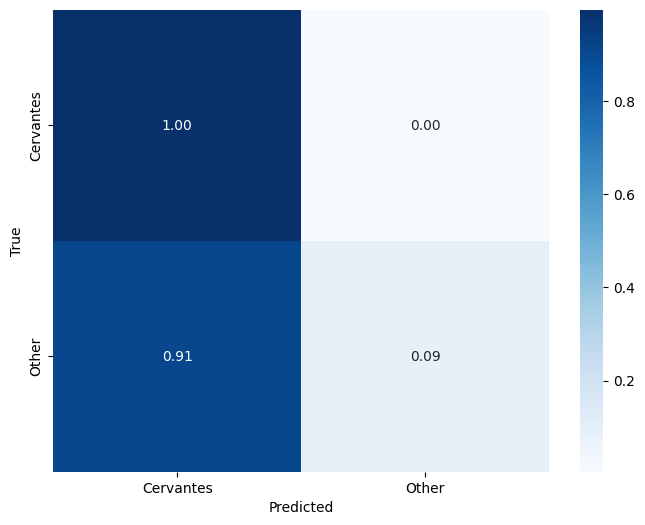

In [82]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test, ensemble_preds, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

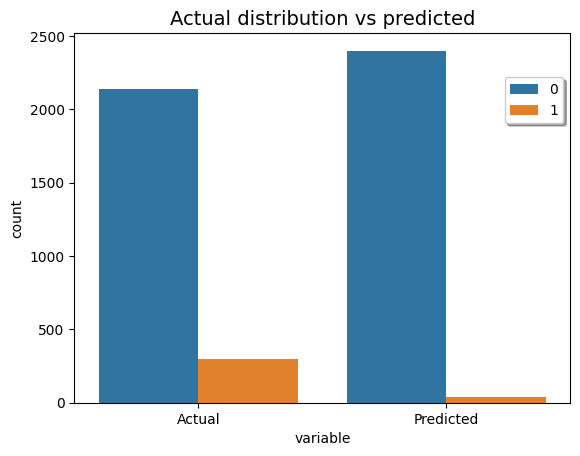

In [81]:
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': ensemble_preds})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

### with weighting

In [42]:
ensemble_preds, f1_score_ensemble = ensemble(predictions=[fw_pred, me_pred, wm_pred, pos_pred], y_test=y_test, threshold=0.2) # ma stesso risultato anche con numeri molto più piccoli
print(classification_report(y_test, ensemble_preds))

#0.8265445631350135

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      2139
           1       0.46      0.21      0.29       297

    accuracy                           0.87      2436
   macro avg       0.68      0.59      0.61      2436
weighted avg       0.85      0.87      0.85      2436



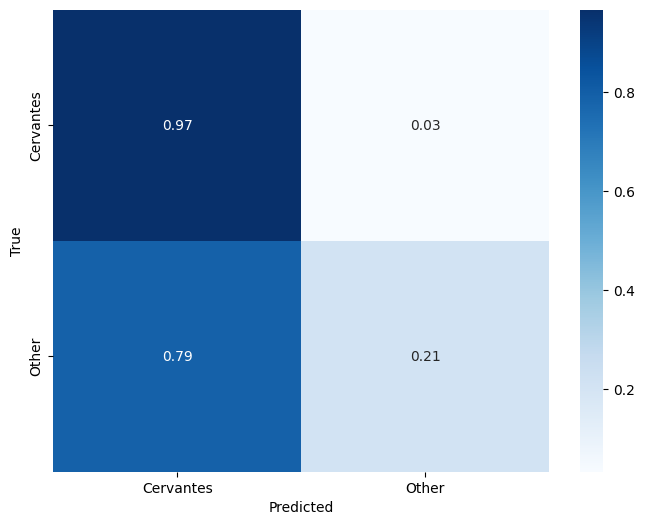

In [44]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test, ensemble_preds, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

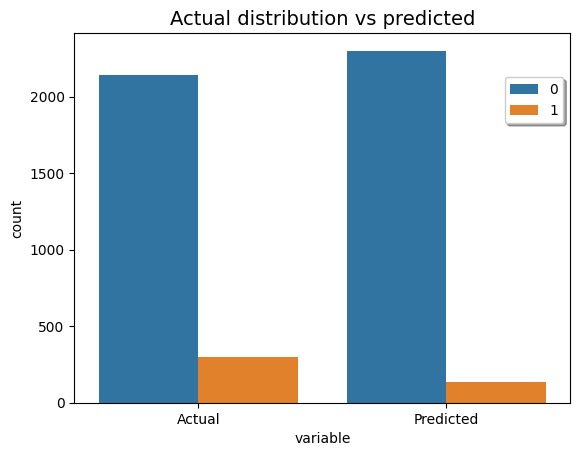

In [43]:
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': ensemble_preds})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

### with probability

In [45]:
probs = [fw_yproba,me_yproba,wm_yproba,pos_yproba]
class_report, y_pred = ensamble_prob(probs, threshold=0.27) #267
print(np.sum(y_pred))
print(class_report)

305
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      2139
           1       0.46      0.47      0.46       297

    accuracy                           0.87      2436
   macro avg       0.69      0.70      0.69      2436
weighted avg       0.87      0.87      0.87      2436



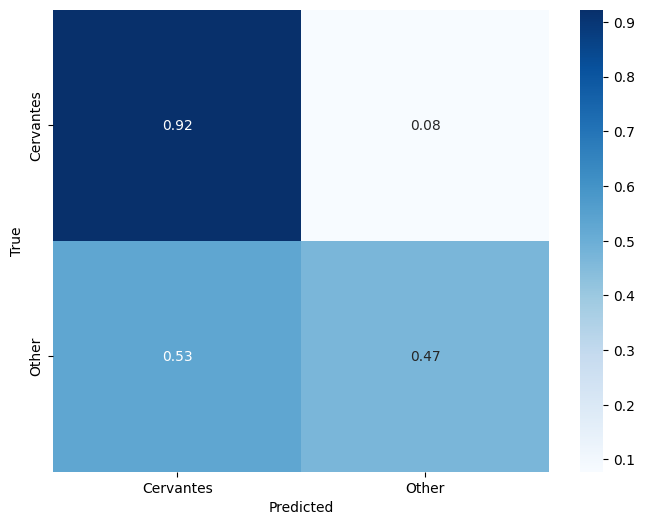

In [46]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

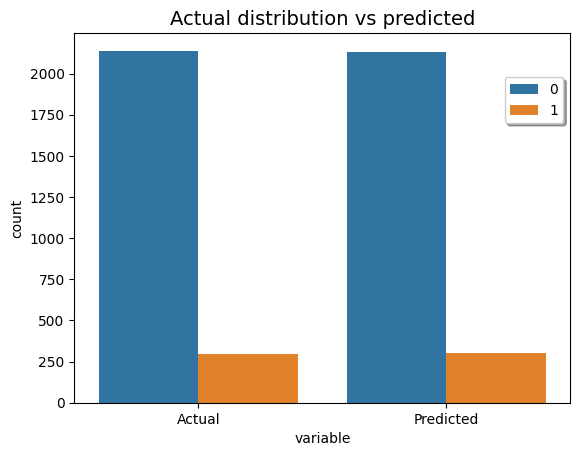

In [47]:
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

### with weighted probability

In [48]:
res = list()
for threshold in np.arange(0.41, 0.59, 0.01):
    for single_threshold in np.arange(0.11, 0.29, 0.01):
        class_report, y_pred = ensamble_prob_weighted(probs, single_threshold=single_threshold, threshold=threshold)
        positive_class_f1 = (class_report.split('\n')[3].split()[3])
        if float(positive_class_f1) > 0:
            res.append((positive_class_f1, (single_threshold, threshold)))
sorted(res, reverse=True)[0]

/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/martinaleo/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/martinaleo/.local/l

('0.48', (0.15999999999999998, 0.55))

In [49]:
class_report, y_pred = ensamble_prob_weighted(probs, threshold=0.55, single_threshold=0.15) #267
print(np.sum(y_pred))
print(class_report)

423
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      2139
           1       0.41      0.59      0.48       297

    accuracy                           0.85      2436
   macro avg       0.68      0.73      0.70      2436
weighted avg       0.87      0.85      0.86      2436



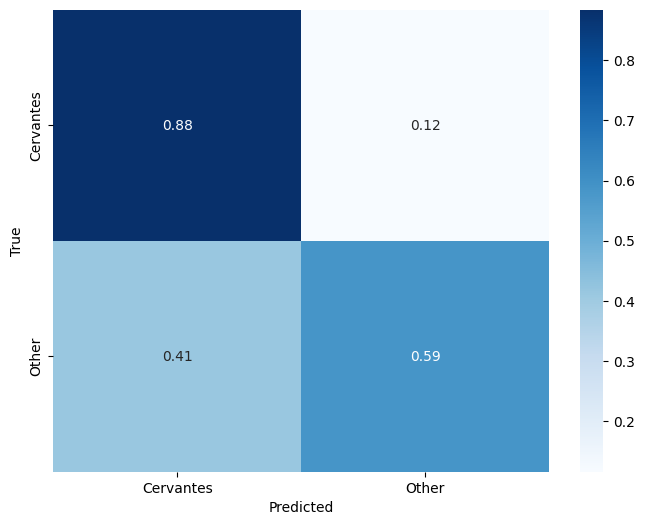

In [50]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


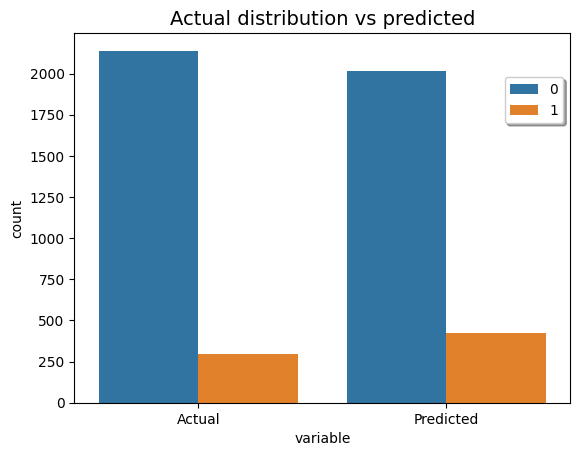

In [51]:
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

## Ensamble & Hyperparameter search \w Pipeline object

In [52]:
function_words_extractor2 = FeaturesFunctionWords(language='spanish')
mendenhall_extractor2 = FeaturesMendenhall(upto=20)
words_masker2 = FeaturesDVEX(function_words=fuction_ws)
sentence_len_extractor2 = FeaturesSentenceLength()
POS_extractor2 = FeaturesPOST(language='spanish')

fw_features = function_words_extractor2.fit_transform(X_dev)
fw_features_test = function_words_extractor2.transform(X_test)

me_features = mendenhall_extractor2.fit_transform(X_dev)
me_features_test = mendenhall_extractor2.transform(X_test)

wm_features = words_masker2.fit_transform(X_dev)
wm_features_test = words_masker2.transform(X_test)

pos_features = POS_extractor2.fit_transform(X_dev)
pos_features_test = POS_extractor2.transform(X_test)

loading cache from .postcache/dict.pkl


In [53]:
feature_sets_dict = {function_words_extractor:fw_features,
                    mendenhall_extractor:me_features,
                    words_masker: wm_features, 
                    POS_extractor:pos_features}
feature_sets_test = [fw_features_test, me_features_test, wm_features_test, pos_features_test]

res_dict = dict()
predictions = list()
probabilities = list()
for idx, (feature_name, feature_set) in enumerate(feature_sets_dict.items()):
    print('Feature exstractor:',feature_name)
    param_grid = [
        {'sel__k': [round(feature_set.shape[1] * val) for val in np.arange(0.1, 1.1, 0.1)], 
        'learner__C': [1, 5, 10],
        'learner__dual': ['auto'],
        'learner__random_state':[42]}
    ]

    fs_clf, fs_pred, fs_score, fs_proba = build_model(X_dev=feature_set, y_dev=y_dev, groups=groups_dev, X_test=feature_sets_test[idx],
                               param_grid=param_grid, pipe=True)
    res_dict[str(feature_name)] = fs_score
    predictions.append(fs_pred)
    probabilities.append(fs_proba)




Feature exstractor: FeaturesFunctionWords


Best: estimator: Pipeline(steps=[('sel',
                 SelectKBest(k=31,
                             score_func=<function chi2 at 0x7f62876e8ee0>)),
                ('learner', LinearSVC(C=1, dual='auto', random_state=42))]) 
Best score: 0.7978663433815221

Feature exstractor: FeaturesMendenhall
Best: estimator: Pipeline(steps=[('sel',
                 SelectKBest(k=2,
                             score_func=<function chi2 at 0x7f62876e8ee0>)),
                ('learner', LinearSVC(C=1, dual='auto', random_state=42))]) 
Best score: 0.8002546250551055

Feature exstractor: FeaturesDVEX
Best: estimator: Pipeline(steps=[('sel',
                 SelectKBest(k=271,
                             score_func=<function chi2 at 0x7f62876e8ee0>)),
                ('learner', LinearSVC(C=1, dual='auto', random_state=42))]) 
Best score: 0.8003992926237273

Feature exstractor: FeaturesPOST
Best: estimator: Pipeline(steps=[('sel',
                 SelectKBest(k=6,
                             score

In [54]:
res_dict

{'FeaturesFunctionWords': 0.7978663433815221,
 'FeaturesMendenhall': 0.8002546250551055,
 'FeaturesDVEX': 0.8003992926237273,
 'FeaturesPOST': 0.7996180624173419}

### with majority vote

In [85]:
thresholds=list()

for threshold in np.arange(0.01, 0.9, 0.05):
    ensemble_preds, f1_score_ensemble = ensemble(predictions=predictions, y_test=y_test, threshold=threshold, majority_vote=True)
    thresholds.append((f1_score_ensemble, threshold, np.sum(ensemble_preds)))
    # print('Threshold:', threshold, 'f1:', f1_score_ensemble)
    # print(np.unique(ensemble_preds, return_counts=True))
    # print()
sorted(thresholds, reverse=True)

[(0.9350819672131147, 0.8600000000000001, 0),
 (0.9350819672131147, 0.81, 0),
 (0.9350819672131147, 0.76, 0),
 (0.9350819672131147, 0.7100000000000001, 0),
 (0.9350819672131147, 0.66, 0),
 (0.9350819672131147, 0.6100000000000001, 0),
 (0.9350819672131147, 0.56, 0),
 (0.9350819672131147, 0.51, 0),
 (0.9328999287354893, 0.46, 8),
 (0.9328999287354893, 0.41000000000000003, 8),
 (0.9328999287354893, 0.36000000000000004, 8),
 (0.9328999287354893, 0.31000000000000005, 8),
 (0.9328999287354893, 0.26, 8),
 (0.9011080442161148, 0.21000000000000002, 99),
 (0.9011080442161148, 0.16000000000000003, 99),
 (0.9011080442161148, 0.11, 99),
 (0.9011080442161148, 0.060000000000000005, 99),
 (0.9011080442161148, 0.01, 99)]

In [86]:
ensemble_preds, f1_score_ensemble = ensemble(predictions=[fw_pred, me_pred, wm_pred, pos_pred], 
                                             y_test=y_test, majority_vote=True, threshold=0.21) 
                                            # ma stesso risultato anche con numeri molto più piccoli
print(classification_report(y_test, ensemble_preds))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      2139
           1       0.46      0.21      0.29       297

    accuracy                           0.87      2436
   macro avg       0.68      0.59      0.61      2436
weighted avg       0.85      0.87      0.85      2436



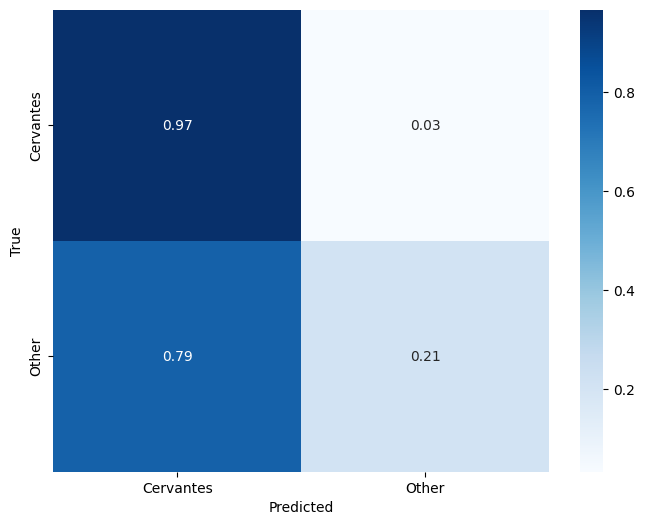

In [87]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test, ensemble_preds, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

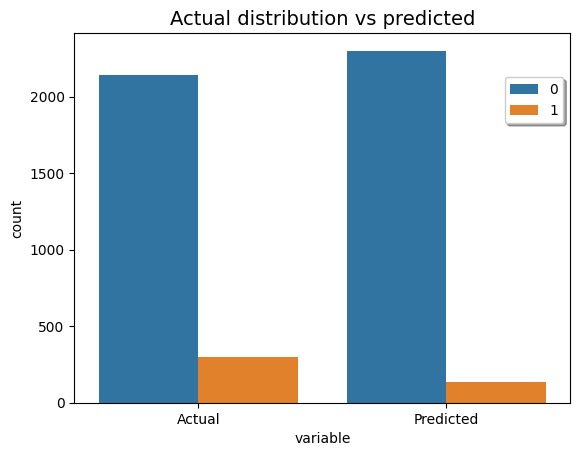

In [88]:
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': ensemble_preds})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

### with weighting

In [55]:
thresholds=list()

for threshold in np.arange(0.01, 0.9, 0.05):
    ensemble_preds, f1_score_ensemble = ensemble(predictions=predictions, y_test=y_test, threshold=threshold)
    thresholds.append((f1_score_ensemble, threshold, np.sum(ensemble_preds)))
    # print('Threshold:', threshold, 'f1:', f1_score_ensemble)
    # print(np.unique(ensemble_preds, return_counts=True))
    # print()
sorted(thresholds, reverse=True)

[(0.9350819672131147, 0.8600000000000001, 0),
 (0.9350819672131147, 0.81, 0),
 (0.9350819672131147, 0.76, 0),
 (0.9350819672131147, 0.7100000000000001, 0),
 (0.9350819672131147, 0.66, 0),
 (0.9350819672131147, 0.6100000000000001, 0),
 (0.9350819672131147, 0.56, 0),
 (0.9350819672131147, 0.51, 0),
 (0.9350819672131147, 0.46, 0),
 (0.9328999287354893, 0.41000000000000003, 8),
 (0.9328999287354893, 0.36000000000000004, 8),
 (0.9328999287354893, 0.31000000000000005, 8),
 (0.9328999287354893, 0.26, 8),
 (0.922613507563538, 0.21000000000000002, 55),
 (0.9011080442161148, 0.16000000000000003, 99),
 (0.9011080442161148, 0.11, 99),
 (0.9011080442161148, 0.060000000000000005, 99),
 (0.9011080442161148, 0.01, 99)]

In [56]:
ensemble_preds, f1_score_ensemble = ensemble(predictions=predictions, y_test=y_test, threshold=0.2)
f1_score_ensemble

0.9011080442161148

In [57]:
print(classification_report(y_test, ensemble_preds))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2139
           1       0.42      0.14      0.21       297

    accuracy                           0.87      2436
   macro avg       0.66      0.56      0.57      2436
weighted avg       0.83      0.87      0.84      2436



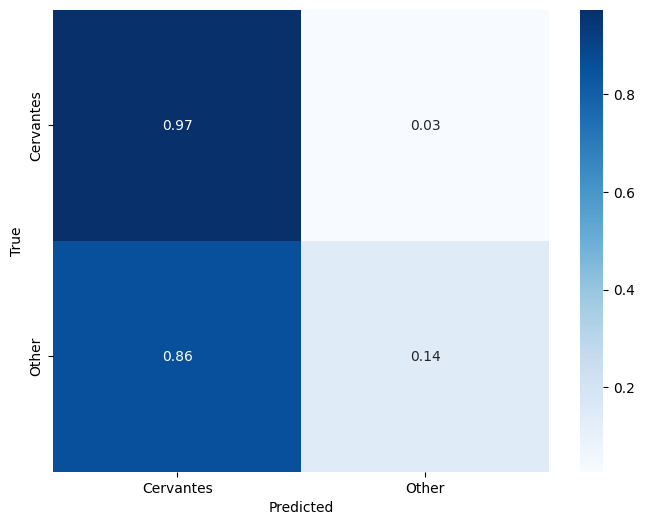

In [58]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test, ensemble_preds, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

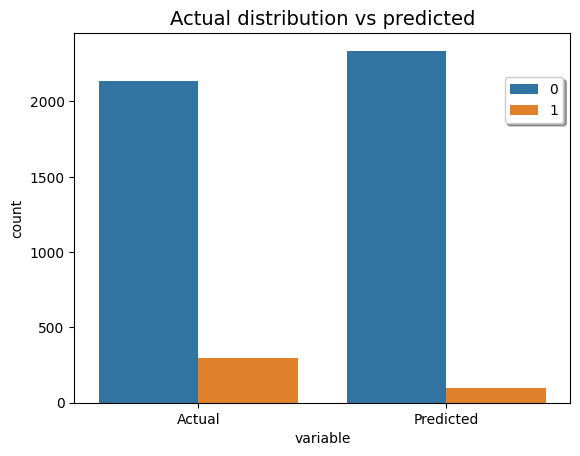

In [59]:
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': ensemble_preds})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

### with probabilities

In [60]:
class_repo, y_pred = ensamble_prob(probabilities=probabilities, threshold=0.25)
print(class_repo)

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2139
           1       0.43      0.51      0.47       297

    accuracy                           0.86      2436
   macro avg       0.68      0.71      0.69      2436
weighted avg       0.87      0.86      0.86      2436



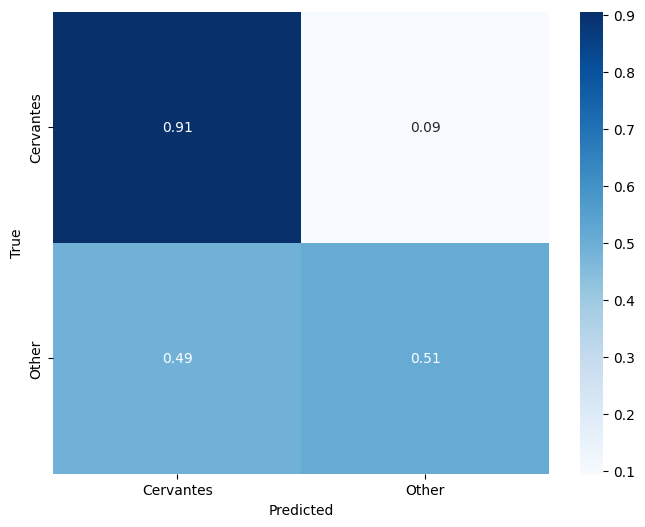

In [61]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

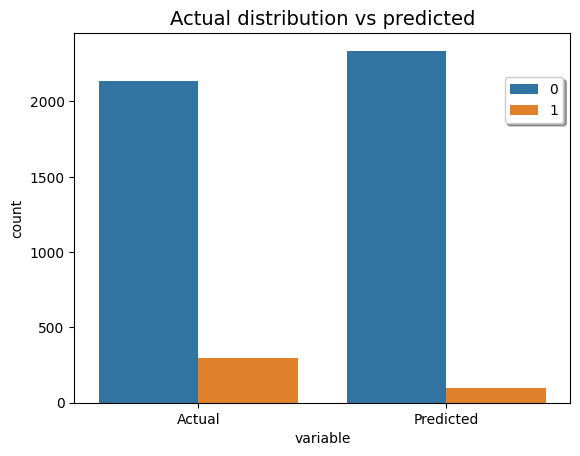

In [62]:
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': ensemble_preds})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

### with weighted probability

In [63]:
res = list()
for threshold in np.arange(0.11, 0.29, 0.01):
    for single_threshold in np.arange(0.21, 0.39, 0.01):
        class_report, y_pred = ensamble_prob_weighted(probabilities, single_threshold=single_threshold, threshold=threshold)
        positive_class_f1 = (class_report.split('\n')[3].split()[3])
        if float(positive_class_f1) > 0:
            res.append((positive_class_f1, (single_threshold, threshold)))
sorted(res, reverse=True)[0]

('0.43', (0.3500000000000001, 0.20999999999999996))

In [64]:
class_report, y_pred = ensamble_prob_weighted(probabilities=probabilities, threshold=0.21, single_threshold=0.35) #267
print(np.sum(y_pred))
print(class_report)

316
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      2139
           1       0.42      0.44      0.43       297

    accuracy                           0.86      2436
   macro avg       0.67      0.68      0.67      2436
weighted avg       0.86      0.86      0.86      2436



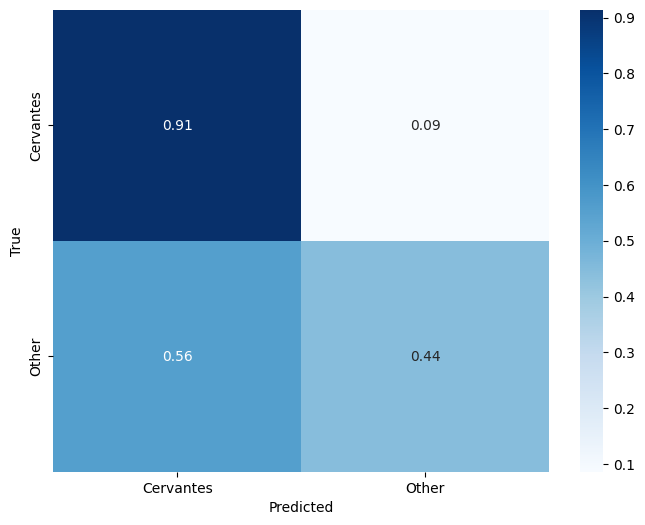

In [65]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

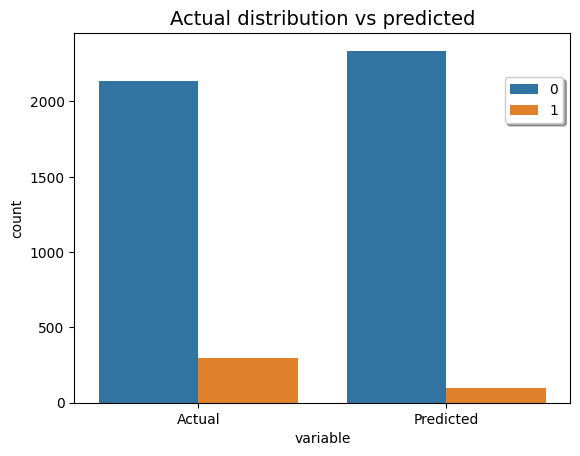

In [66]:
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': ensemble_preds})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

# Classification with one classifier

In [67]:
X_dev = hstacked_features
X_test = hstacked_features_test

In [68]:
clf = LinearSVC(random_state=42, dual='auto', class_weight='balanced')
scores = cross_val_score(clf, X_dev, y_dev, cv=5, groups=groups_dev)
scores.mean(), scores.std()

(0.7217525804539167, 0.09718647569653326)

In [69]:
clf = LinearSVC(random_state=42, dual='auto', class_weight='balanced')      
clf.fit(X_dev, y_dev)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print('Accuracy:', acc) 
print('Weighted f1:',f1)

Accuracy: 0.8066502463054187
Weighted f1: 0.8298801844817033


In [70]:
param_grid= {'C': [140], #1, 10, 100, 200
             'dual': ['auto'],
             'random_state': [0]}

grid = GridSearchCV(
            clf,
            param_grid=param_grid,
            cv=5,
            n_jobs=-1)

grid.fit(X_dev, y_dev)
grid.best_estimator_, grid.best_score_

(LinearSVC(C=140, class_weight='balanced', dual='auto', random_state=0),
 0.7266920531646981)

In [71]:
clf = grid.best_estimator_
y_pred = clf.predict(X_test)

In [72]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.83      0.88      2139
           1       0.35      0.67      0.46       297

    accuracy                           0.81      2436
   macro avg       0.65      0.75      0.67      2436
weighted avg       0.87      0.81      0.83      2436



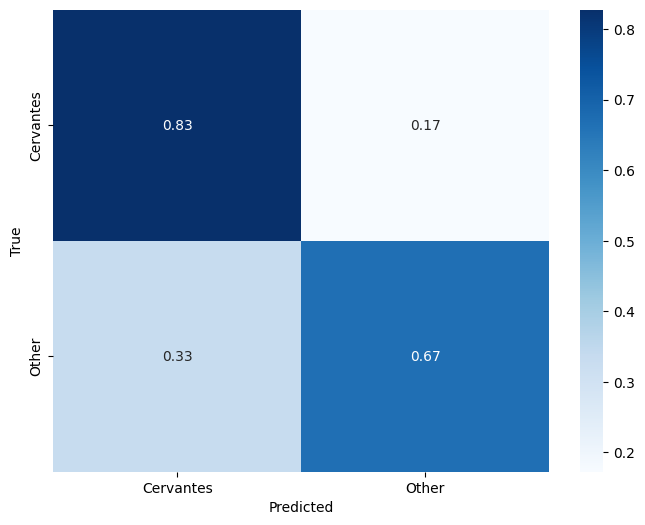

In [73]:
plt.subplots(figsize=(8,6))
cf = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cf, annot=True, fmt='.2f', cmap="Blues", xticklabels=y_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

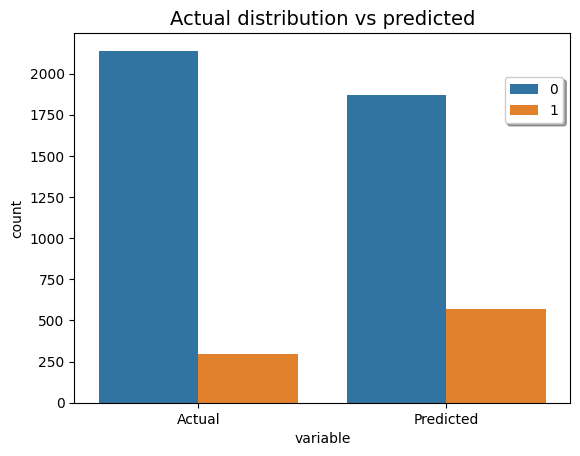

In [74]:
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
sns.countplot(x="variable", hue="value", data=pd.melt(df_res))
plt.title('Actual distribution vs predicted', fontsize=14)

plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()

# Model Evaluation

In [75]:
confidence_scores = clf.decision_function(X_test)
print('Confidence Scores:')
for score, pred, true in zip(confidence_scores, y_pred, y_test):
    print(score, pred, true)

Confidence Scores:
-0.06435652383687973 0 0
1.2012637505294599 1 1
-1.5616335431548674 0 0
-0.5627061305232779 0 0
1.116854798725175 1 1
-0.0418749128375957 0 0
-0.7695730010094461 0 0
1.13046379129886 1 1
0.7468518281306284 1 1
-1.0405690037563193 0 0
-0.8212546497812898 0 0
-2.851115888260857 0 0
-4.639876163322838 0 0
-1.721703722166577 0 0
-2.093838222378462 0 0
-1.8015760548825828 0 0
-2.037521585122475 0 0
-2.138385676066152 0 0
-2.002764756106883 0 0
-1.6978667450616456 0 0
-0.21285624772342615 0 0
-1.8563381881613488 0 0
-2.831887937881005 0 0
-1.597688966925066 0 0
-1.3513327211050665 0 0
-1.4202396095900198 0 0
-2.587451901838234 0 0
-1.2610307230694673 0 0
-0.8869473556026239 0 0
-2.333654152737811 0 0
-1.721131675957734 0 0
-2.750939579424495 0 0
-1.7863859164599507 0 0
-2.123389548787289 0 0
-1.6384493208335797 0 0
-2.1931363116445812 0 0
0.03212142493747017 1 0
-3.7664115789443233 0 0
-2.6713016060086225 0 0
-2.115313315615106 0 0
-1.6124085423173842 0 0
-5.04023860335400

In [76]:
clf = CalibratedClassifierCV(clf) 
clf.fit(X_dev, y_dev)
y_proba = clf.predict_proba(X_test)

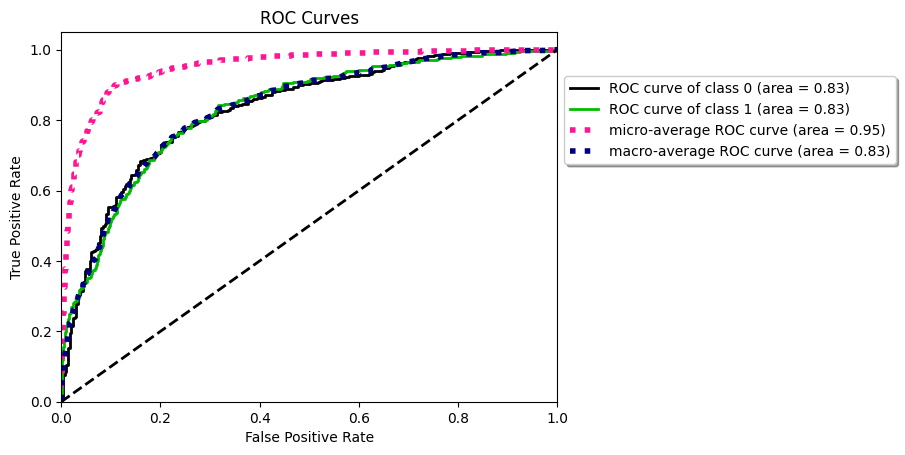

In [77]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.legend(loc='best', bbox_to_anchor=(1, 0.9), fancybox=True, shadow=True)
plt.show()
#print(roc_auc_score(y_test, y_proba))